<a href="https://colab.research.google.com/github/borismikwa/Pre-training-Neural-Networks-On-Xeno-Canto-and-Ebird-for-Bioacoustic-Classification-Models/blob/main/aug_12000_with_collected_noise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pickle
import librosa.display
import librosa
import numpy as np
import pandas as pd
from PIL import Image
from keras.models import Sequential
import tensorflow as tf
from scipy import interp
from itertools import cycle
from keras.layers import Conv2D, MaxPooling2D,MaxPool2D
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.optimizers import SGD,Adam,Adamax
from sklearn.metrics import confusion_matrix, roc_auc_score,precision_recall_fscore_support,roc_curve,auc,f1_score,plot_confusion_matrix,multilabel_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
#from sklearn.metrics import f1_score
import matplotlib
import matplotlib.pylab as plt
from google.colab import files
from imblearn.over_sampling import SMOTE,RandomOverSampler
from collections import Counter
from keras import models
import librosa.display
import librosa
import sklearn.metrics as metrics
import math

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


Function to load Pickle file from Drive

In [ ]:
def upload(feature, label):
  infile = open(feature,'rb')
  x= pickle.load(infile)
  infile.close()

  infile = open(label,'rb')
  y= pickle.load(infile)
  infile.close()

  return x, y

def save_data_to_pickle( feature, label):
        '''
        Save all of the spectrograms to a pickle file.
        
        '''
        outfile = open(feature,'wb')
        pickle.dump(X, outfile, protocol=4)
        outfile.close()
        
        outfile = open(label,'wb')
        pickle.dump(Y, outfile, protocol=4)
        outfile.close()


Confussion matrix function

In [ ]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Reds')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

Upload CRC

In [ ]:
crc_x, y_crc = upload('/content/drive/MyDrive/Thesis/Secondary_data/augmented/crc_5000.pkl','/content/drive/MyDrive/Thesis/Secondary_data/augmented/y_crc_5000')

In [ ]:
crc_x = crc_x[0:4000]
y_crc =  y_crc[0:4000]

In [ ]:
crc_x.shape

(4000, 128, 216, 1)

In [ ]:
y_crc.shape

(4000,)

In [ ]:
np.unique(y_crc)

array(['CRC'], dtype='<U7')

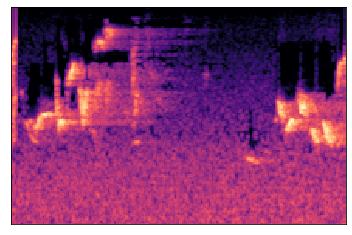

In [ ]:
librosa.display.specshow(crc_x[19,:,:,0])

Upload PTW

In [ ]:
ptw_x, y_ptw = upload('/content/drive/MyDrive/Thesis/Secondary_data/augmented/ptw_5000.pkl','/content/drive/MyDrive/Thesis/Secondary_data/augmented/y_ptw_5000')

In [ ]:
to_use_x = ptw_x[4500:5000]
to_use_y = y_ptw[4500:5000]

In [ ]:
ptw_x = ptw_x[0:4000]
y_ptw = y_ptw[0:4000]

In [ ]:
ptw_x.shape

(4000, 128, 216, 1)

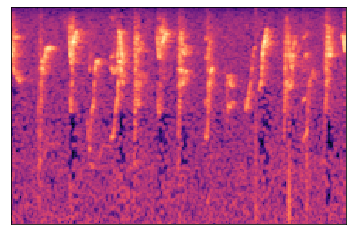

In [ ]:
librosa.display.specshow(ptw_x[19,:,:,0])

Upload NOISE

In [ ]:
#noise_x, y_noise = upload('/content/drive/MyDrive/Thesis/Secondary_data/augmented/noise_5000.pkl','/content/drive/MyDrive/Thesis/Secondary_data/augmented/y_noise_5000')
x_n,y_n=upload('/content/drive/MyDrive/Thesis/Secondary_data/xc_ebird_data/X.pkl','/content/drive/MyDrive/Thesis/Secondary_data/xc_ebird_data/Y.pkl')
noise_x1, y_noise1 = upload('/content/drive/MyDrive/Thesis/Primary_data/train/X_noise1.pkl','/content/drive/MyDrive/Thesis/Primary_data/train/Y_noise1.pkl') # load noise

noise_indices = np.where(y_n=="NOISE")
noise_x_n = x_n[noise_indices]
noise_y_n = y_n[y_n=="NOISE"]

In [ ]:
noise_x = np.concatenate([noise_x_n ,noise_x1],axis=0)
y_noise = np.concatenate([noise_y_n,y_noise1],axis=0)

In [ ]:
noise_to_add_x = noise_x[4500:5000]
noise_to_add_y = y_noise[4500:5000]
noise_to_add_y.shape

(500,)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
noise_x =noise_x[0:4000]
y_noise  = y_noise[0:4000]

In [ ]:
noise_x.shape

(4000, 128, 216, 1)

In [ ]:
np.unique(y_noise)

array(['NOISE'], dtype='<U7')

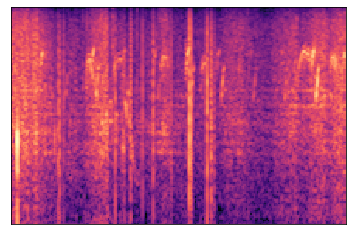

In [ ]:
librosa.display.specshow(noise_x[100,:,:,0])

In [ ]:
X = np.concatenate([crc_x, ptw_x,noise_x], axis=0)
Y = np.concatenate([y_crc, y_ptw,y_noise], axis=0)

In [ ]:
X.shape

(12000, 128, 216, 1)

In [ ]:
Y.shape

(12000,)

(array([4000.,    0.,    0.,    0.,    0., 4000.,    0.,    0.,    0.,
        4000.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

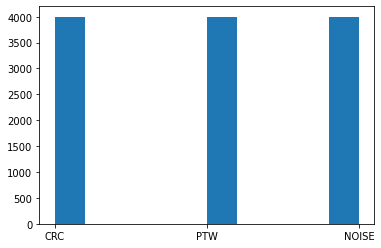

In [ ]:
plt.hist(Y)

**Label Encoding**

In [ ]:
l_enc = preprocessing.LabelEncoder()
l_enc.fit(Y)
print(l_enc.classes_)
y_enc =l_enc.transform(Y)
l_enc.classes_

['CRC' 'NOISE' 'PTW']


array(['CRC', 'NOISE', 'PTW'], dtype='<U7')

**One hot encoding**

In [ ]:
y = tf.keras.utils.to_categorical(y_enc, num_classes=None, dtype="float32")

In [ ]:
y.shape

(12000, 3)

**Train Test Split**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=42)

In [ ]:
y_test.shape

(2400, 3)

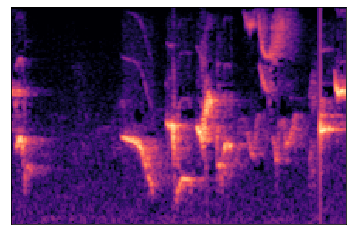

In [ ]:
librosa.display.specshow(X_test[2,:,:,0])

**Train A Model**

In [ ]:
model = Sequential()
# CONVOLUTIONAL LAYER
model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=(128, 216, 1), activation='relu'))
# POOLING LAYER
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
#model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
#model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
#model.add(MaxPool2D(pool_size=(2, 2)))
#model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
#model.add(MaxPool2D(pool_size=(2, 2)))
# model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu'))
# model.add(MaxPool2D(pool_size=(2, 2)))
#
model.add(Flatten())
# 128 NEURONS IN DENSE HIDDEN LAYER
# model.add(Dense(32, activation='relu'))
# model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))
lr = 0.01
#checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5", save_best_only=True)
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/Thesis/Primary_data/pre_trained/aug_12000_collected_data_update2",
                                                   monitor= 'val_accuracy',save_best_only=True)
early_stop = EarlyStopping(monitor='val_accuracy',patience=10)
history = model.fit(X_train,y_train,epochs=100,validation_data=(X_test,y_test),callbacks=[early_stop,checkpoint_cb])


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 126, 214, 32)      320       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 63, 107, 32)       0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 61, 105, 32)       9248      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 30, 52, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 28, 50, 32)        9248      
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 26, 48, 32)        9248      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 13, 24, 32)       

Save the model

In [ ]:
model.save("/content/drive/MyDrive/Thesis/Secondary_data/model_saved_12000/model_chp3")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Thesis/Secondary_data/model_saved_12000/model_chp3/assets


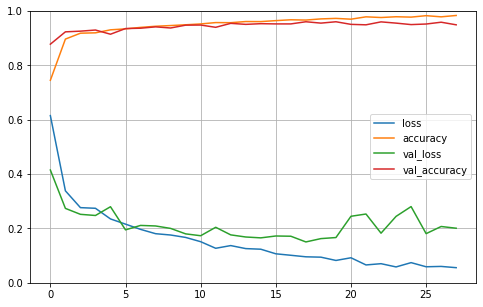

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [ ]:
model.evaluate(X_test,y_test)

75/75 [==============================] - 0s 5ms/step - loss: 0.2959 - accuracy: 0.9542


[0.29593729972839355, 0.9541666507720947]

In [ ]:
#new_model = models.load_model('/content/drive/MyDrive/Thesis/Primary_data/pre_trained/aug_12000_collected_data_update1')
#new_model = models.load_model('/content/drive/MyDrive/Thesis/Primary_data/pre_trained/aug_9000_collected_data')
new_model = models.load_model('/content/drive/MyDrive/Thesis/Primary_data/pre_trained/aug_15000_with_collect_data')


In [ ]:
#new_model.evaluate(X_test,y_test)

Load Test Data

In [ ]:
X_testing, Y_testing = upload('/content/drive/MyDrive/Thesis/Secondary_data/test_data/X.pkl','/content/drive/MyDrive/Thesis/Secondary_data/test_data/Y.pkl')

In [ ]:
# X_testing = np.concatenate([X_testing,to_use_x,noise_to_add_x],axis=0)
# Y_testing = np.concatenate([Y_testing,to_use_y,noise_to_add_y],axis=0)


In [ ]:
X_testing.shape

(1145, 128, 216, 1)

In [ ]:
Y_testing.shape

(1145,)

In [ ]:
#Label encoding
le = preprocessing.LabelEncoder()
le.fit(Y_testing)
print(le.classes_)
y_enc_test =le.transform(Y_testing)
le.classes_

['CRC' 'NOISE' 'PTW']


array(['CRC', 'NOISE', 'PTW'], dtype='<U7')

In [ ]:
testing_y = tf.keras.utils.to_categorical(y_enc_test, num_classes=None, dtype="float32")

In [ ]:
new_model.evaluate(X_testing,testing_y)

36/36 [==============================] - 26s 8ms/step - loss: 0.0279 - accuracy: 0.9921


[0.027915580198168755, 0.9921397566795349]

In [ ]:
p_pred = np.argmax(new_model.predict(X_testing),axis=1)

In [ ]:
con_matrix =  metrics.confusion_matrix(y_enc_test,p_pred)
con_matrix

array([[139,   2,   1],
       [  2, 501,   0],
       [  0,   4, 496]])

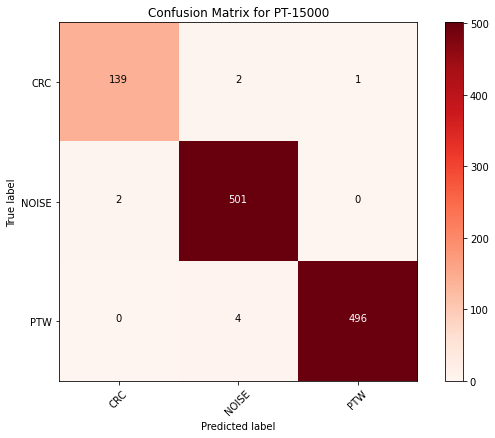

In [ ]:
plot_confusion_matrix(cm = con_matrix,target_names=['CRC','NOISE','PTW'], normalize=False, title= "Confusion Matrix for PT-15000")

In [ ]:
precision_recall_fscore_support(y_enc_test, p_pred, average='macro')

(0.9906564036252149, 0.9889656987651555, 0.9897987727541392, None)

AUC

In [ ]:
y_pred= new_model.predict(X_testing)

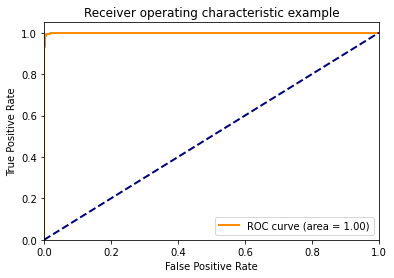

In [ ]:
n_classes = 3

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(testing_y[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(testing_y.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

Multiclass

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  import sys


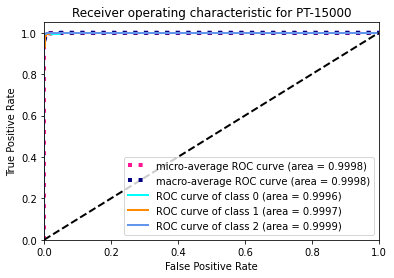

In [ ]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.4f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.4f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.4f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for PT-15000')
plt.legend(loc="lower right")
plt.show()